In [ ]:
'''
from google.colab import drive
drive.mount('/content/gdrive')'''

Mounted at /content/gdrive


In [ ]:
'''
import os
path="/content/gdrive/My Drive"
os.chdir(path)
os.listdir(path)'''

['net_config (6).cpython-37.pyc',
 '.ipynb_checkpoints',
 'net_config (5).cpython-37.pyc',
 'EnsembleModel (1).cpython-37.pyc',
 'net_config (4).cpython-37.pyc',
 'EnsembleModel.cpython-37.pyc',
 'net_config (3).cpython-37.pyc',
 'seqGAN',
 'ML_dialogue',
 'seqGAN_tran.ipynb',
 '6000J',
 '5002',
 '5012',
 'exam5003',
 'net_config (2).cpython-37.pyc',
 'MultiLabelTextClassification',
 'net_config (1).cpython-37.pyc',
 'net_config.cpython-37.pyc',
 'MAAL.ipynb',
 '5002final',
 'MSBD5002_Fall2021_Final_Data']

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import preprocessing
import datetime
from dateutil.parser import parse 
import pytz 
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score ,roc_curve, auc, roc_auc_score
import torch.nn.functional as F
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA


In [ ]:
data = pd.read_csv('MSBD5002_Fall2021_Final_Data/Q4/fraudTrain.csv')

In [ ]:
data.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0


In [ ]:
y = data['is_fraud']
print("Number of positive samples = %s" % sum(y==1))
print("Number of negative samples = %s" % sum(y==0))

Number of positive samples = 7506
Number of negative samples = 1289169


In [ ]:
def preprocess():
    data = pd.read_csv('MSBD5002_Fall2021_Final_Data/Q4/fraudTrain.csv')
    #data = data.head(20)
    y = data['is_fraud']
    
    ts_objs = np.array([pd.Timestamp(item) for item in np.array(data.trans_date_trans_time)])
    data['Ts_obj'] = ts_objs
    data['DayName'] = data['Ts_obj'].apply(lambda d: d.day_name())
    data['Minute'] = data['Ts_obj'].apply(lambda d: d.minute)
    data['Second'] = data['Ts_obj'].apply(lambda d: d.second)
    
    ts_objs = np.array([pd.Timestamp(item) for item in np.array(data.dob)])
    data['Ts_obj'] = ts_objs
    data['Year_holder'] = data['Ts_obj'].apply(lambda d: d.year)
    data['Month_holder'] = data['Ts_obj'].apply(lambda d: d.month)
    data['Day_holder'] = data['Ts_obj'].apply(lambda d: d.day)
    
    drop_feat = []
    data.drop(['Unnamed: 0','is_fraud','Ts_obj','trans_date_trans_time','unix_time','merchant'],axis=1,inplace=True)

    # Data separate
    feature_dim = {}
    for columnName, columnData in data.iteritems():
        if columnName not in ['Day_holder','Month_holder','Year_holder','Second','Minute','Hour','DayName','Month','Year','trans_date_trans_time','category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num']: 
            continue
        count = columnData.value_counts().count()
        #feature_dim[columnName] = count
        if count>100:
            drop_feat.append(columnName)
            continue
        feature_dim[columnName] = count
            
    data.drop(drop_feat,axis=1,inplace=True)
    #feature_dim_discrete = {k: v for k, v in feature_dim.items() if k not in drop_feat}
    discrete_keys = feature_dim.keys()
    
    data = pd.get_dummies(data, prefix=discrete_keys,  prefix_sep='_', columns=discrete_keys)
    pca = PCA(n_components=100)
    data = pca.fit_transform(data)
    smote = SMOTE(random_state=0,sampling_strategy={1:50000}) 
    data, y = smote.fit_resample(data, y)
    print("Number of positive samples = %s" % sum(y==1))
    print("Number of negative samples = %s" % sum(y==0))
    ## Train and valid split
    x_train,x_test,y_train,y_test = train_test_split(data, y, test_size = 0.1,random_state=1)
    
    imp = SimpleImputer(verbose=2)
    x_train = imp.fit_transform(x_train)
#     valid_data = imp.fit_transform(valid_data)
    x_test = imp.fit_transform(x_test)
    x_train = preprocessing.robust_scale(x_train)
#     valid_data = preprocessing.robust_scale(valid_data)
    x_test = preprocessing.robust_scale(x_test)
    
    
    return x_train,x_test,y_train,y_test

In [ ]:
y.head(1)

0    0
Name: is_fraud, dtype: int64

In [ ]:
data.shape

(1296675, 23)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score ,roc_curve, auc, roc_auc_score
import seaborn as sns

def evaluation(test_y, y_pred):
  #AUC-ROC
  y_true = F.one_hot(torch.tensor(test_y, dtype=torch.long), num_classes = 2)
  y_true = np.array(y_true)

        
  plt.figure(figsize=(8, 5))
  colors = ['darkorange', 'cornflowerblue']
  fpr, tpr, roc_auc = dict(), dict(), dict()
  for i in range(2):
      fpr[i], tpr[i], threshold = roc_curve(y_true[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      plt.plot(fpr[i], tpr[i], color=colors[i], label='ROC curve of class %d (area = %.3f)' % (i,roc_auc[i]))
                
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
x_train,x_test,y_train,y_test = preprocess()

Number of positive samples = 50000
Number of negative samples = 1289169


In [ ]:
x_train.shape

(1205252, 100)

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=30,learning_rate= 0.2,max_depth=90,objective='binary:logistic',eval_metric='auc')
xgb.fit(x_train, y_train)
y_pred=xgb.predict_proba(x_test)
#evaluation(y_test, y_pred)
#xbg = XGBClassifier(random_state=0)

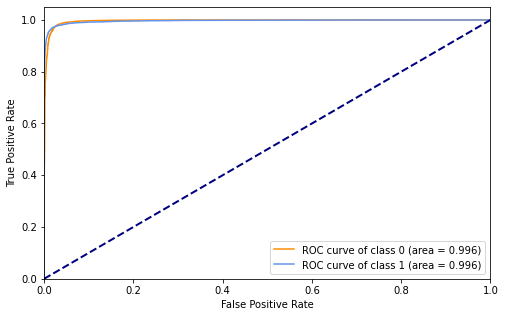

In [ ]:
evaluation(y_test, y_pred)

In [ ]:
_, y_pred = torch.max(torch.tensor(y_pred), dim=1)
y_pred  =y_pred.numpy()
y_pred.shape

(133917,)

In [ ]:
print("Accuracy : %.4g" % accuracy_score(y_test, y_pred))

Accuracy : 0.993


              precision    recall  f1-score   support

           0       0.99      1.00      1.00    128953
           1       0.96      0.85      0.90      4964

    accuracy                           0.99    133917
   macro avg       0.98      0.92      0.95    133917
weighted avg       0.99      0.99      0.99    133917



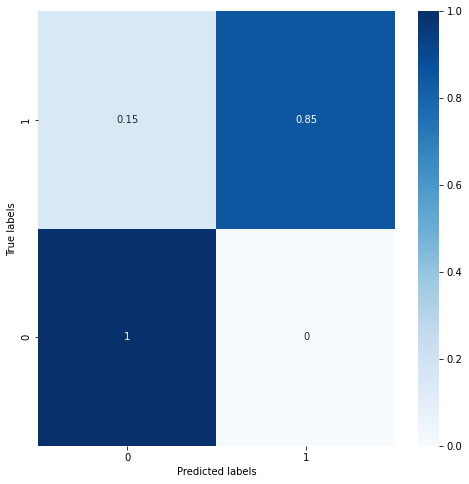

In [ ]:
acc = accuracy_score(y_test, y_pred)
classification_report(y_test, y_pred)
 
 #peint calssification report
print(classification_report(y_test, y_pred))
 
 #build confusion matrix
con_mat = confusion_matrix(y_test, y_pred, labels=[0, 1])
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis] # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)
 #plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
plt.ylim(0, 2)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


**Output**

In [ ]:
y_pred=xgb.predict_proba(np.concatenate([x_train,x_test],axis=0))
_, y_pred = torch.max(torch.tensor(y_pred), dim=1)
y_pred  = y_pred.numpy()
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('5002final/wjy/Q4_output.csv',header=False,index=False)

In [ ]:
from xgboost import XGBClassifier
#xgb = XGBClassifier(n_estimators=100,learning_rate= 0.3,max_depth=20, gamma=0.1, seed=1)
xbg = XGBClassifier(random_state=0)
param = {'max_depth': [100, 80],
            'n_estimators': [50, 80, 100],
         'learning_rate': [0.1,0.3]
            }
gsCv = GridSearchCV(xbg, param, cv=5)
gsCv.fit(x_train, y_train)
    
best = gsCv.best_params_
    
xbg = XGBClassifier(**best,random_state=0)
xbg.fit(x_train, y_train)
    

y_pred=xbg.predict(x_test)

# 计算精度
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, y_pred))